# Loading Data

- Loading CoNLL 2003 Dataset from hugging face datasets
- Loading Train, Validation and Test Split

In [ ]:
! pip install datasets > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import nltk
import string
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier
from string import punctuation
from tqdm.notebook import tqdm
from datasets import load_dataset, concatenate_datasets
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

nltk.download('punkt')
nltk.download("stopwords")
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [ ]:
dataset = load_dataset("conll2003", trust_remote_code=True)

num_train_sentences = len(dataset['train'])
num_val_sentences = len(dataset['validation'])
num_test_sentences = len(dataset['test'])

print(f"Number of sentences in the training set: {num_train_sentences}")
print(f"Number of sentences in the validation set: {num_val_sentences}")
print(f"Number of sentences in the test set: {num_test_sentences}")

print(dataset)

for i in range(5):
    print(len(dataset['train'][i]['tokens']), len(dataset['train'][i]['ner_tags']))
    print(" ".join(dataset['train'][i]['tokens']))
    print(dataset['train'][i]['ner_tags'])
    print(dataset['train'][i]['chunk_tags'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Number of sentences in the training set: 14041
Number of sentences in the validation set: 3250
Number of sentences in the test set: 3453
DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})
9 9
EU rejects German call to boycott British lamb .
[3, 0, 7, 0, 0, 0, 7, 0, 0]
[11, 21, 11, 12, 21, 22, 11, 12, 0]
2 2
Peter Blackburn
[1, 2]
[11, 12]
2 2
BRUSSELS 1996-08-22
[5, 0]
[11, 12]
30 30
The European Commission said on Thursday it disagreed with German advice to consumers to shun British lamb until scientists determine whether mad cow disease can be transmitted to sheep .
[0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
dataset['train'] = concatenate_datasets([dataset['train'], dataset['validation']])

In [ ]:
all_tokens = set()
for split in ['train', 'test', 'validation']:
    for example in dataset[split]:
        all_tokens.update(example['tokens'])
print("Unique Tokens: ", len(all_tokens))

Unique Tokens:  30289


# Preprocessing Dataset for Training and Testing
- Converting sequences of words into features.
    - First word is capital: 0/1
    - All words are capital: 0/1
    - Is stopword: 0/1
    - Is Punctuation: 0/1
    - Length of word: integer
    - Position of word feature: position/len(sentence)
    - POS Tags: integer

- Using Standard Scaler to standardize features

In [ ]:
def preprocess_ner_tags(example):
    example['label'] = [1 if tag != 0 else 0 for tag in example['ner_tags']]
    return example

dataset = dataset.map(preprocess_ner_tags)

In [ ]:
for i in range(5):
    print(len(dataset['train'][i]['tokens']), len(dataset['train'][i]['ner_tags']))
    print(" ".join(dataset['train'][i]['tokens']))
    print(dataset['train'][i]['ner_tags'])
    print(dataset['train'][i]['chunk_tags'])
    print(dataset['train'][i]['label'])

9 9
EU rejects German call to boycott British lamb .
[3, 0, 7, 0, 0, 0, 7, 0, 0]
[11, 21, 11, 12, 21, 22, 11, 12, 0]
[1, 0, 1, 0, 0, 0, 1, 0, 0]
2 2
Peter Blackburn
[1, 2]
[11, 12]
[1, 1]
2 2
BRUSSELS 1996-08-22
[5, 0]
[11, 12]
[1, 0]
30 30
The European Commission said on Thursday it disagreed with German advice to consumers to shun British lamb until scientists determine whether mad cow disease can be transmitted to sheep .
[0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[11, 12, 12, 21, 13, 11, 11, 21, 13, 11, 12, 13, 11, 21, 22, 11, 12, 17, 11, 21, 17, 11, 12, 12, 21, 22, 22, 13, 11, 0]
[0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
31 31
Germany 's representative to the European Union 's veterinary committee Werner Zwingmann said on Wednesday consumers should buy sheepmeat from countries other than Britain until the scientific advice was clearer .
[5, 0, 0, 0, 0, 3, 4, 0, 0, 0, 1, 2, 0, 0, 0, 0, 

In [ ]:
def get_pos_tags(sentence, tokens=False, numerical=False):
    pos_mapping = {p: i for i, p in enumerate(["ADJ", "ADP", "ADV", "CONJ", "DET", "NOUN", "NUM", "PRT", "PRON", "VERB", ".", "X"])}
    if not tokens:
        sentence = word_tokenize(sentence)
    if numerical:
        return [pos_mapping[v[1]] for v in pos_tag(sentence, tagset='universal')]
    return [v[1] for v in pos_tag(sentence, tagset='universal')]

In [ ]:
get_pos_tags("He was fined and ordered to pay", tokens=False, numerical=False)

['PRON', 'VERB', 'VERB', 'CONJ', 'VERB', 'PRT', 'VERB']

In [ ]:
get_pos_tags("He was fined and ordered to pay", tokens=False, numerical=True)

[8, 9, 9, 3, 9, 7, 9]

In [ ]:
class PreProcessData:
    def __init__(self, seed):
        self.seed = seed
        self.stop_words = stopwords.words("english")
        self.puncts = list(string.punctuation)

    def preprocess_data(self, dt):
        X = []
        y = []
        for idx in tqdm(range(len(dt))):
            tokens = dt[idx]['tokens']
            labels = dt[idx]['label']
            pos_tags_info = get_pos_tags(tokens, tokens=True, numerical=True)
            for i in range(len(tokens)):
                word_feat = self.create_word_feature(tokens[i], idx/len(tokens))
                word_feat[6] = pos_tags_info[i]
                X.append(word_feat)
                y.append(labels[i])
        return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

    def create_feature(self, sentence):
        features = []
        tokens = word_tokenize(sentence)
        pos_tags_info = get_pos_tags(tokens, tokens=True, numerical=True)
        for idx, word in enumerate(tokens):
            word_feat = self.create_word_feature(word, idx/len(tokens))
            word_feat[6] = pos_tags_info[idx]
            features.append(word_feat)
        return tokens, np.array(features, dtype=np.float32)

    def create_word_feature(self, word, position_feature):
        feat = np.zeros(7).astype(np.float32)
        # check first letter is uppercase
        feat[0] = 1 if word[0].isupper() else 0
        # is stopword
        feat[1] = 1 if word.lower() in self.stop_words else 0
        # is punctuation
        feat[2] = 1 if word in self.puncts else 0
        # position feature
        feat[3] = position_feature
        # length of word
        feat[4] = len(word)
        # all character capital
        feat[5] = 1 if word.isupper() else 0
        return feat

In [ ]:
def save_model(model, filename):
    with open(filename, 'wb') as handler:
        pickle.dump(model, handler)

def load_model(filename):
    with open(filename, 'rb') as handler:
        return pickle.load(handler)

In [ ]:
processor = PreProcessData(seed=42)

In [ ]:
X_train, y_train = processor.preprocess_data(dataset['train'])
X_val, y_val = processor.preprocess_data(dataset['validation'])
X_test, y_test = processor.preprocess_data(dataset['test'])

  0%|          | 0/17291 [00:00<?, ?it/s]

  0%|          | 0/3250 [00:00<?, ?it/s]

  0%|          | 0/3453 [00:00<?, ?it/s]

In [ ]:
scaler = StandardScaler()
scaler = scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

In [ ]:
save_model(scaler, "scaler.pkl")

In [ ]:
print("Data Shape: ")
print("trainX: ", X_train.shape, "trainy: ", y_train.shape)
print("valX: ", X_val.shape, "valy: ", y_val.shape)
print("testX: ", X_test.shape, "testy: ", y_test.shape)

Data Shape: 
trainX:  (254983, 7) trainy:  (254983,)
valX:  (51362, 7) valy:  (51362,)
testX:  (46435, 7) testy:  (46435,)


# Training

## Linear SVM with SGD or Linear SVC
- Recommended for large dataset, it was able to train very fast

## LibSVM
- Training is very slow, takes lot of time

### Linear SGD SVM

In [ ]:
svm_sgd = SGDClassifier(
    loss='hinge',
    alpha=1e-5,
    learning_rate='optimal',
    max_iter=3000,
    class_weight="balanced",
    random_state=42,
    tol=1e-5,
    warm_start=True,
    verbose=True,
    early_stopping=True,
    n_jobs=-1
)

svm_sgd.fit(X_train, y_train)

-- Epoch 1
Norm: 7.88, NNZs: 7, Bias: -8.142652, T: 229484, Avg. loss: 2.215047
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 5.92, NNZs: 7, Bias: -3.528073, T: 458968, Avg. loss: 0.470641
Total training time: 0.07 seconds.
-- Epoch 3
Norm: 3.06, NNZs: 7, Bias: -3.369608, T: 688452, Avg. loss: 0.317489
Total training time: 0.12 seconds.
-- Epoch 4
Norm: 2.57, NNZs: 7, Bias: -2.049259, T: 917936, Avg. loss: 0.252876
Total training time: 0.16 seconds.
-- Epoch 5
Norm: 2.63, NNZs: 7, Bias: -2.346223, T: 1147420, Avg. loss: 0.215399
Total training time: 0.21 seconds.
-- Epoch 6
Norm: 2.75, NNZs: 7, Bias: -1.942963, T: 1376904, Avg. loss: 0.190003
Total training time: 0.25 seconds.
-- Epoch 7
Norm: 2.40, NNZs: 7, Bias: -1.974270, T: 1606388, Avg. loss: 0.174746
Total training time: 0.30 seconds.
-- Epoch 8
Norm: 2.00, NNZs: 7, Bias: -1.763646, T: 1835872, Avg. loss: 0.165416
Total training time: 0.35 seconds.
-- Epoch 9
Norm: 1.86, NNZs: 7, Bias: -1.882675, T: 2065356, Avg. loss: 0.15

SGDClassifier(alpha=1e-05, class_weight='balanced', early_stopping=True,
              max_iter=3000, n_jobs=-1, random_state=42, tol=1e-05,
              verbose=True, warm_start=True)

In [ ]:
y_pred = svm_sgd.predict(X_test)
y_pred = np.asarray(y_pred, dtype=np.int32)

In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Non-entity", "Named Entity"]))


Classification Report:
              precision    recall  f1-score   support

  Non-entity       1.00      0.94      0.97     38323
Named Entity       0.79      0.98      0.87      8112

    accuracy                           0.95     46435
   macro avg       0.89      0.96      0.92     46435
weighted avg       0.96      0.95      0.95     46435



In [ ]:
save_model(svm_sgd, "svm_sgd.pkl")

### Linear SVC

In [ ]:
svm_linear = LinearSVC(C = 1.0,
                       class_weight = "balanced",
                       random_state = 42,
                       loss="hinge",
                       verbose = True)

svm_linear.fit(X_train, y_train)

[LibLinear]

LinearSVC(class_weight='balanced', loss='hinge', random_state=42, verbose=True)

In [ ]:
y_pred = svm_linear.predict(X_test)
y_pred = np.asarray(y_pred, dtype=np.int32)

In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Non-entity", "Named Entity"]))


Classification Report:
              precision    recall  f1-score   support

  Non-entity       1.00      0.94      0.97     38323
Named Entity       0.79      0.98      0.87      8112

    accuracy                           0.95     46435
   macro avg       0.89      0.96      0.92     46435
weighted avg       0.96      0.95      0.95     46435



In [ ]:
save_model(svm_linear, "svm_linear.pkl")

In [ ]:
len(np.intersect1d(np.asarray(y_test, dtype=np.int32), y_pred)) == 0

False

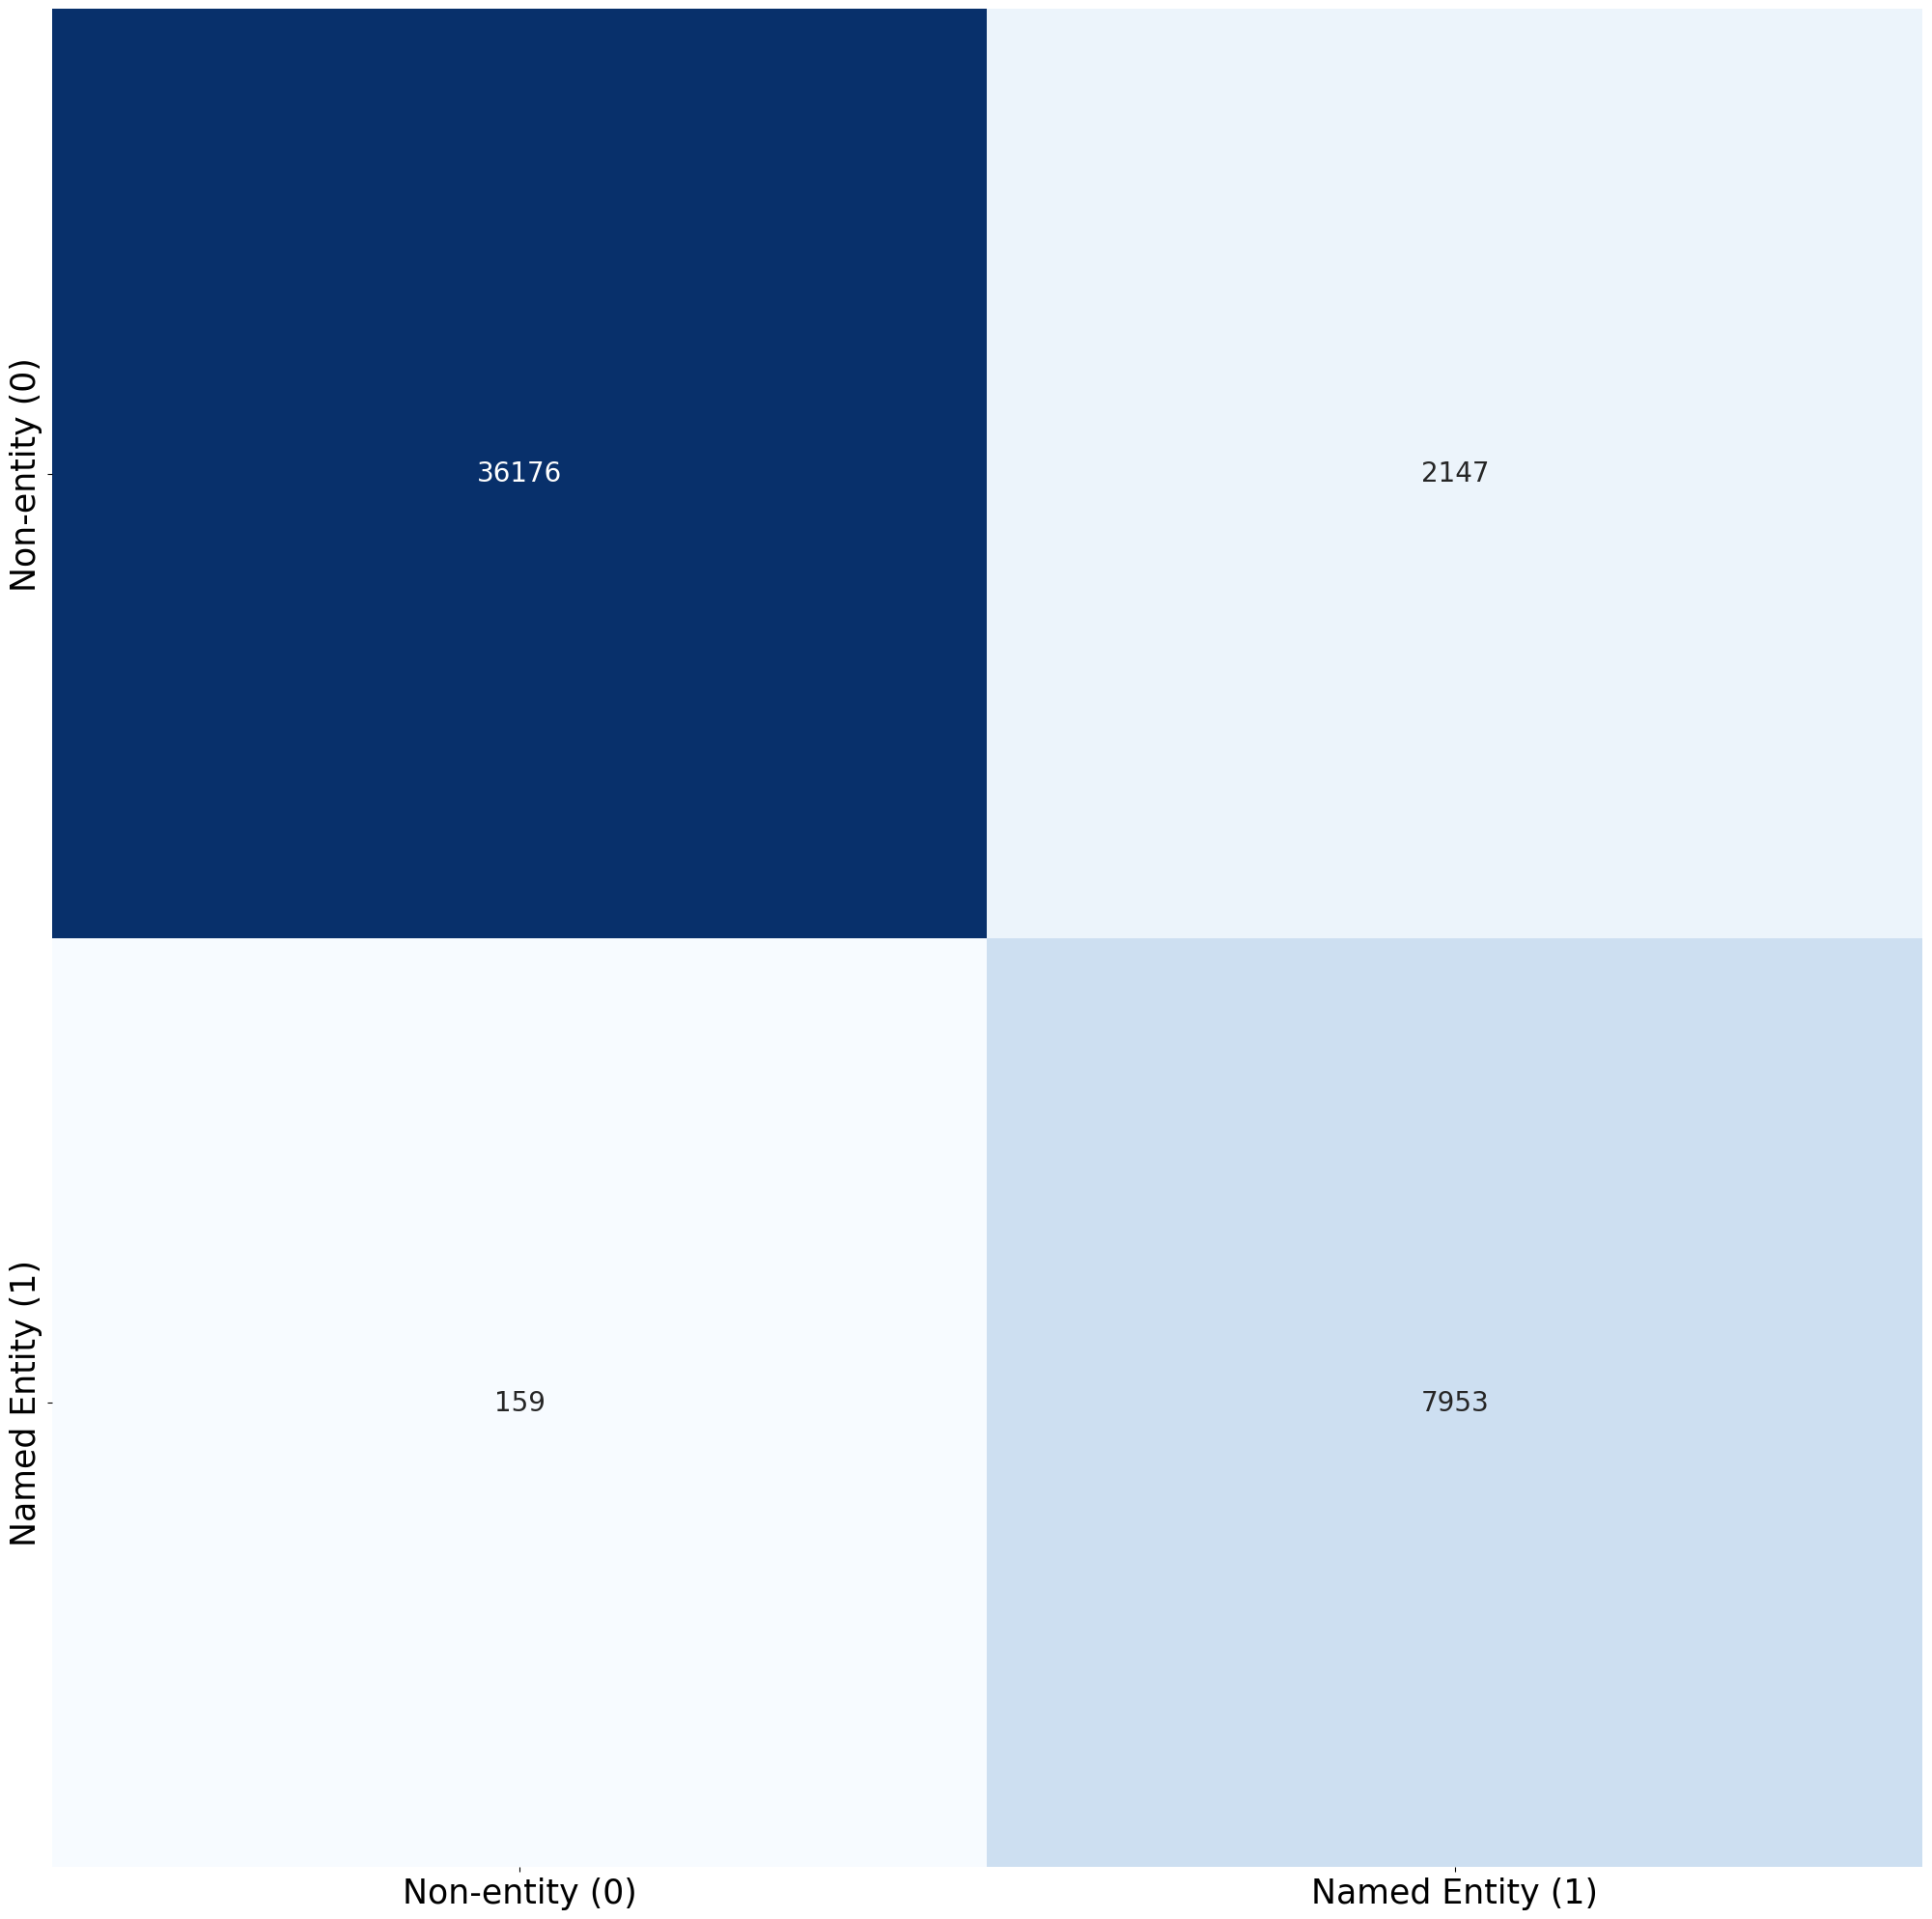

In [ ]:
plot_label = ["Non-entity (0)", "Named Entity (1)"]
cm = confusion_matrix(np.asarray(y_test, dtype=np.int32), y_pred, labels=[0, 1])
plt.figure(figsize=(25, 25))
ax = sns.heatmap(cm, annot=True,
                 fmt='d',
                 cmap='Blues',
                 xticklabels=plot_label,
                 yticklabels=plot_label,
                 cbar=False,
                 annot_kws={"size": 20})
ax.tick_params(axis='both', which='major', labelsize=25)
plt.show()

# Inference Demo

In [ ]:
def inference(processor, sentence, model):
    tokens, features = processor.create_feature(sentence)
    features = scaler.transform(features)
    return tokens, np.asarray(model.predict(features), dtype=np.int32)

In [ ]:
model_name = "svm_linear.pkl"
scaler = load_model("scaler.pkl")
model = load_model(model_name)

In [ ]:
demo_sentence = "Thursday 200 Last week Holiday Last Year N / A"
result = inference(processor, demo_sentence, model)
print(result)

(['Thursday', '200', 'Last', 'week', 'Holiday', 'Last', 'Year', 'N', '/', 'A'], array([1, 0, 1, 0, 1, 1, 1, 1, 0, 0], dtype=int32))


### LibSVM
- Slow Training

In [ ]:
# libsvm = LinearSVC(C = 1.0,
#                        class_weight = "balanced",
#                        random_state = 42,
#                        loss="hinge",
#                        verbose = True)

# libsvm.fit(X_train, y_train)

In [ ]:
# y_pred = libsvm.predict(X_test)

In [ ]:
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred, target_names=["Non-entity", "Named Entity"]))

In [ ]:
# save_model(libsvm, "lib_svm.pkl")

# Retrieve all Error Cases

In [ ]:
error_cases = {"sentence":[],
               "label":[],
               "prediction": [],
               "trues": [],
               "model_preds": [],
               "num_mistakes": [],
               "mistake_indices": []
               }

for sent in tqdm(dataset['test']):
    tokens = " ".join(sent['tokens'])
    labels = sent['label']
    tokens, features = processor.create_feature(tokens)
    features = scaler.transform(features)
    pred = np.asarray(svm_linear.predict(features), dtype=np.int32)
    mismatch_indices = [i for i, (lbl, p) in enumerate(zip(labels, pred)) if lbl != p]
    num_mistakes = len(mismatch_indices)
    if num_mistakes > 0:
        error_cases["sentence"].append(" ".join(tokens))
        error_cases["label"].append(" ".join([str(lbl) for lbl in labels]))
        error_cases["prediction"].append(" ".join([str(p) for p in pred]))
        error_cases["trues"].append(" ".join([f"{t}_{lbl}" for t, lbl in zip(tokens, labels)]))
        error_cases["model_preds"].append(" ".join([f"{t}_{lbl}" for t, lbl in zip(tokens, pred)]))
        error_cases["num_mistakes"].append(num_mistakes)
        error_cases["mistake_indices"].append(", ".join(map(str, mismatch_indices)))

print("Number of Error Cases: ", len(error_cases["sentence"]))
pd.DataFrame(error_cases).to_csv("error_cases.csv")

  0%|          | 0/3453 [00:00<?, ?it/s]

Number of Error Cases:  1513


In [ ]:
error_csv = pd.read_csv("error_cases.csv")
error_csv.head()

,Unnamed: 0,sentence,label,prediction,trues,model_preds,num_mistakes,mistake_indices
0,0,"SOCCER - JAPAN GET LUCKY WIN , CHINA IN SURPRI...",0 0 1 0 0 0 0 1 0 0 0 0,1 0 1 1 1 1 0 1 0 1 1 0,"SOCCER_0 -_0 JAPAN_1 GET_0 LUCKY_0 WIN_0 ,_0 C...","SOCCER_1 -_0 JAPAN_1 GET_1 LUCKY_1 WIN_1 ,_0 C...",6,"0, 3, 4, 5, 9, 10"
1,1,Japan began the defence of their Asian Cup tit...,1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0,1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0,Japan_1 began_0 the_0 defence_0 of_0 their_0 A...,Japan_1 began_0 the_0 defence_0 of_0 their_0 A...,3,"18, 19, 23"
2,2,Despite winning the Asian Games title two year...,0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0,1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0,Despite_0 winning_0 the_0 Asian_1 Games_1 titl...,Despite_1 winning_0 the_0 Asian_1 Games_1 titl...,1,0
3,3,Two goals from defensive errors in the last si...,0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 ...,1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 ...,Two_0 goals_0 from_0 defensive_0 errors_0 in_0...,Two_1 goals_0 from_0 defensive_0 errors_0 in_0...,1,0
4,4,Defender Hassan Abbas rose to intercept a long...,0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,Defender_0 Hassan_1 Abbas_1 rose_0 to_0 interc...,Defender_1 Hassan_1 Abbas_1 rose_0 to_0 interc...,1,0


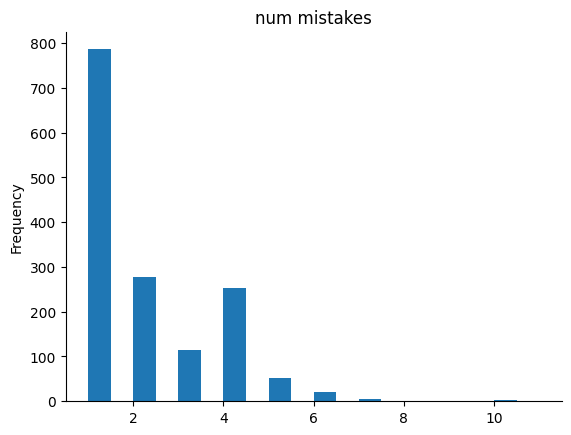

In [ ]:
error_csv['num_mistakes'].plot(kind='hist', bins=20, title='num mistakes')
plt.gca().spines[['top', 'right',]].set_visible(False)